<a href="https://colab.research.google.com/github/jy6zheng/FacialExpressionRecognition/blob/master/Facial_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import fastai
print(fastai.__version__)
import torch
print(torch.__version__)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

1.0.61
1.8.0+cu101


# Process Data

In [3]:
ls 'drive/MyDrive/AIHealthcare/FacialExpressionRecognition/FacialExpressionRecognition-master/archive.zip'

drive/MyDrive/AIHealthcare/FacialExpressionRecognition/FacialExpressionRecognition-master/archive.zip


In [4]:
%cd drive/MyDrive/AIHealthcare/FacialExpressionRecognition/FacialExpressionRecognition-master

/content/drive/MyDrive/AIHealthcare/FacialExpressionRecognition/FacialExpressionRecognition-master


In [5]:
!unzip -o archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [6]:
ls

a/                                   images/
archive.zip                          liveVideoFrameRead.py
export.pkl                           README.md
Facial_recognition.ipynb             shape_predictor_68_face_landmarks.dat
haarcascade_frontalface_default.xml  videoFrameRead.py


In [7]:
np.random.seed(42)
path_data = Path('images/images')
data = ImageDataBunch.from_folder(path_data, train="train", valid="validation",ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
data.valid_ds

LabelList (7066 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
angry,angry,angry,angry,angry
Path: images/images

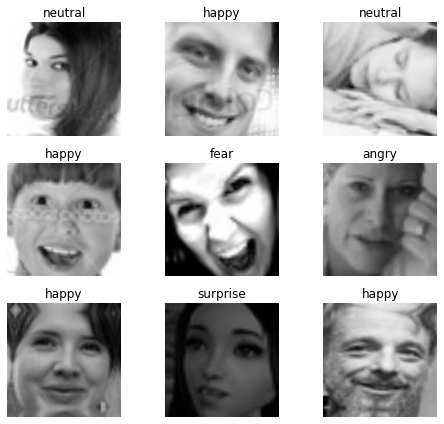

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
print(data.classes)
len(data.classes),data.c

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


(7, 7)

# Training

We will use a learner to train the model. The learner takes in the image data bunch as well as the resnet34 architecture to train the model. The metrics will be used to print the error_rate when training

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Then we train the dataset. With learn.fit_one_cycle(4) we pass in the complete dataset four times. After 4 epochs, the error has been decreased to 29.8%

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.717082,1.489682,0.570195,03:53
1,1.451781,1.311426,0.495471,03:55
2,1.322579,1.196574,0.454288,03:55
3,1.251874,1.163931,0.439711,03:53


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
learn.save('stage-1')

In [14]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (28821 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
angry,angry,angry,angry,angry
Path: images/images;

Valid: LabelList (7066 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
angry,angry,angry,angry,angry
Path: images/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Before, we were only training the few extra layers of the model near the end. With **learn.unfreeze()** we are able to train the whole model. </br>
Then we find the learning rate, and the plot of loss over learning rate. From there, we find where the steepest downward slope of loss occurs (around 1e-4) and use it to fit 8 more epochs

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


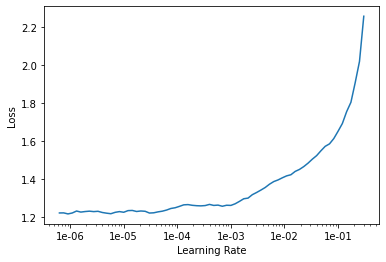

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(8, max_lr=slice(1e-4,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.125152,1.024576,0.379140,04:02
1,1.033074,0.962076,0.358053,04:03
2,0.974308,0.924516,0.344042,04:03
3,0.895417,0.866425,0.318143,04:03
4,0.784657,0.823346,0.300736,04:03
5,0.695274,0.799339,0.285310,04:07
6,0.593921,0.791473,0.280215,04:21
7,0.519608,0.793894,0.279083,04:26


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
learn.save('stage-2')

In [20]:
learn.load('stage-2');

# Interpreting Results

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


For interpreting the results, it is clear from the confusion matrix that sad and neutral faces are often confused. This makes sense since many of the sad and neutral faces are similar and hard to distinguish

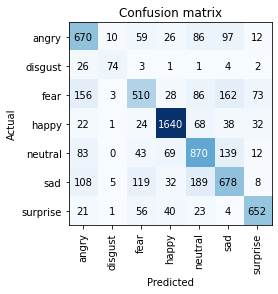

In [22]:
interp.plot_confusion_matrix()

Also, looking at the photos that caused the top losses, (difference between the predicted and the actual label) it is also clear that some data is still dirty and mislabelled, therefore there is still room for improvement

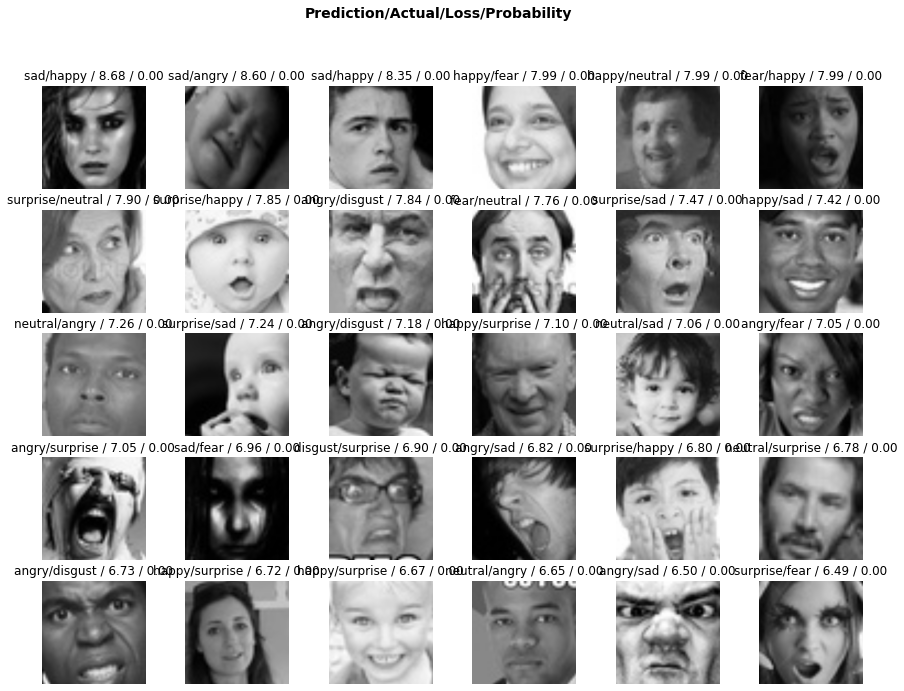

In [23]:
interp.plot_top_losses(30, figsize=(15,11))

Now export the model, and download it (export.pkl)

In [24]:
learn.export()

In [25]:
load_learner

<function fastai.basic_train.load_learner>